In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import brentq

# Defining the metric (adaptive threshold-based)

Let the absolute residuals be defined as:

$$
\varepsilon_i = \left| y_i^{\text{true}} - y_i^{\text{sim}} \right|
$$

We define SCAS as the solution to the fixed-point equation, denoted as $\tau$:

$$
\tau = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1} \left\{ \varepsilon_i < (1 - \tau) \cdot \sigma \right\}
$$

where $\sigma $ is a scale parameter (e.g., standard deviation of $y^{\text{true}}$), and $\mathbf{1}(\cdot)$ is the indicator function.
r function.

In [50]:
def _mad(x):
    return np.median(np.abs(x - np.median(x)))

def _scale_y(y, prefer='sd'):
    """Return scale of y; prefer 'sd' but fall back to MAD if needed."""
    if prefer == 'mad':
        return 1.4826 * _mad(y)
    s = np.std(y, ddof=1)
    if not np.isfinite(s) or s <= 0:
        s = 1.4826 * _mad(y)
    # final guard:
    if not np.isfinite(s) or s <= 0:
        s = 1.0
    return s

def SCAS(y_true, y_pred, tol=1e-6, prefer_scale='sd'):
    """
    Self-Consisted Agreement Score as the fixed point of G ↦ P(|e| < (1−G) * S_y) − G.
    S_y defaults to std(y_true) with robust fallback to MAD.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    e = np.abs(y_true - y_pred)

    # Handle trivial cases first
    if np.allclose(e, 0):
        return 1.0

    S = _scale_y(y_true, prefer=prefer_scale)

    def f(G):
        thr = (1.0 - G) * S
        # If thr <= 0, P(|e| < thr) = 0 unless there are exact zeros:
        if thr <= 0:
            return (np.mean(e < 0.0)) - G 
        return np.mean(e < thr) - G

    # Ensure a valid bracket on [0,1]
    f0 = f(0.0)      # = P(|e| < S) ≥ 0
    f1 = f(1.0)      # = P(|e| < 0) - 1 ≈ -1
    if f0 < 0:       # extremely pathological; clamp
        return 0.0
    if f1 > 0:       # only if all e == 0 (handled above), but guard anyway
        return 1.0

    tau = brentq(f, 0.0, 1.0, xtol=tol)
    return float(tau)

def TBA(y_true, y_pred, k=0.05, prefer_scale='sd'):
    """
    Tolerance-based Acurracy (TBA) at tolerance k  -> A(k) using sigma_ref from y_true (std by default, MAD fallback).
    Uses strict '<'.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    e = np.abs(y_true - y_pred)
    sigma_ref = _scale_y(y_true, prefer=prefer_scale)
    thr = k * sigma_ref
    # if thr <= 0, accuracy is 0 unless all errors are 0
    if thr <= 0:
        return float(np.mean(e < 0.0))
    return float(np.mean(e < thr))

def compute_metrics(y_true, y_pred, ks=(0.05, 0.1, 0.2, 0.5), prefer_scale="sd"):
    out = {"SCAS": SCAS(y_true, y_pred, prefer_scale=prefer_scale), "R2": r2_score(y_true, y_pred)}
    for k in ks:
        out[f"A({k})"] = TBA(y_true, y_pred, k=k, prefer_scale=prefer_scale)
    return out


In [52]:
STYLE = {
    "SCAS":    dict(color="#d62728", marker="o", linestyle="-",  label="SCAS"),     # red
    "R2":      dict(color="#000000", marker="x", linestyle="-",  label="R²"),       # black
    "A(0.05)": dict(color="#6a3d9a", marker="^", linestyle="--", label="A(0.05)"),  # purple
    "A(0.1)":  dict(color="#1f78b4", marker="v", linestyle="--", label="A(0.1)"),   # blue
    "A(0.2)":  dict(color="#008080", marker="D", linestyle="--", label="A(0.2)"),   # teal
    "A(0.5)":  dict(color="#4c9bdc", marker="P", linestyle="--", label="A(0.5)"),   # light
}

# Experiment 1: Single outlier

In [11]:
# Synthetic Sine function data
x = np.linspace(0, 2*np.pi, 20)
y_true = np.sin(x)

sd = np.std(y_true)

# Add a slight noise
y = np.sin(x + np.random.uniform(-0.1*sd, 0.1*sd, size=len(x)))
y[10] += 10*sd  # introduce outlier

# Real world Brownlee's stackloss dataset
import statsmodels.api as sm
data = sm.datasets.stackloss.load_pandas().data

In [12]:
# Plot tau finding
def find_tau(y_true, y_sim, name=None):
    residuals = np.abs(y_true - y_sim)
    sigma = np.std(y_true)
    N = len(residuals)
    
    def f_tau(tau, residuals, sigma):
        threshold = (1 - tau) * sigma
        return np.mean(residuals < threshold)
    
    # Generate values of tau in [0, 1]
    tau_values = np.linspace(0, 1, 500)
    f_values = [f_tau(tau, residuals, sigma) for tau in tau_values]
    
    plt.figure(figsize=(8, 6))
    plt.plot(tau_values, f_values, label=r'$f(\tau)$')
    plt.plot(tau_values, tau_values, 'r--', label=r'$\tau$ (identity line)')
    plt.xlabel(r'$\tau$', fontsize=14)
    plt.ylabel(r'$f(\tau)$', fontsize=14)
    plt.title(f'Fixed-Point Visualization - {name}', fontsize=16)
    plt.legend(fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid(False)
    plt.savefig(f'SCAS_{name}_Latest SCAS find')
    plt.show()

## 1a) Synthetic data

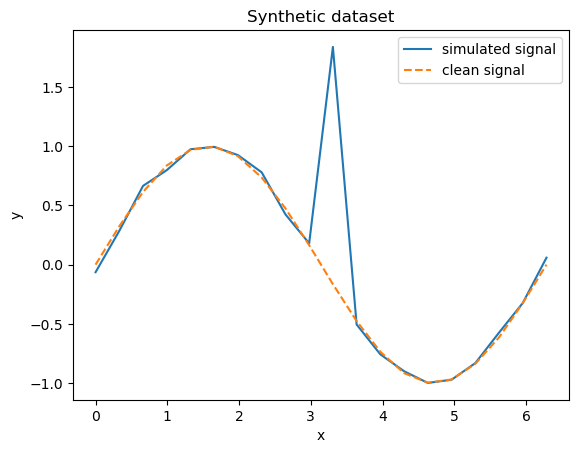

In [14]:
# Add a slight noise
y = np.sin(x + np.random.uniform(-0.1*sd, 0.1*sd, size=len(x)))
y[10] += 3*sd  # introduce outlier
y_sim = y

plt.plot(x, y, label='simulated signal')
plt.plot(x, y_true, linestyle='dashed', label='clean signal')
plt.ylabel('y')
plt.xlabel('x')
plt.title('Synthetic dataset')
plt.legend()
plt.savefig('New dataset Figure - Sine function with an outlier - 3S.png', dpi=900)
plt.show()

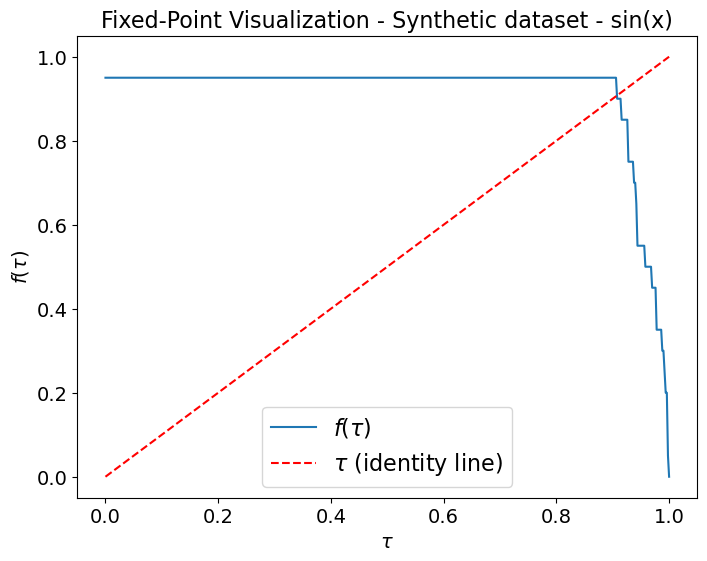

SCAS: 0.910111789806263
r2 score: 0.5754033692780847
A(0.05): 0.55
A(0.1): 0.55
A(0.2): 0.55
A(0.5): 0.55


In [17]:
find_tau(y_true, y_sim, name='Synthetic dataset - sin(x)')
print(f'SCAS: {SCAS(y_true, y_sim)}')
print(f'r2 score: {r2_score(y_true, y_sim)}')
for k in [0.05, 0.1, 0.2, 0.5]:
    print(f'A({k}): {TBA(y_true, y_sim)}')

## 1b) Real-world data

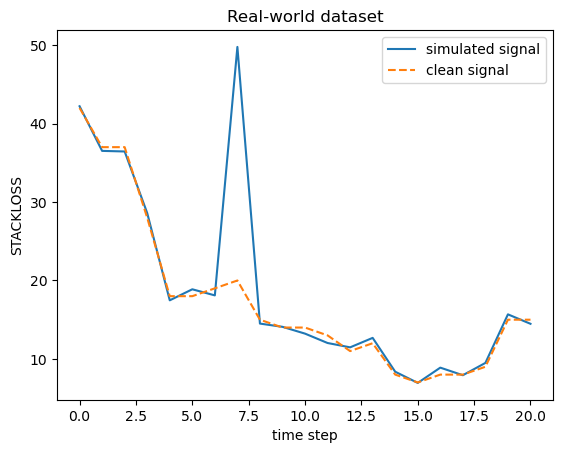

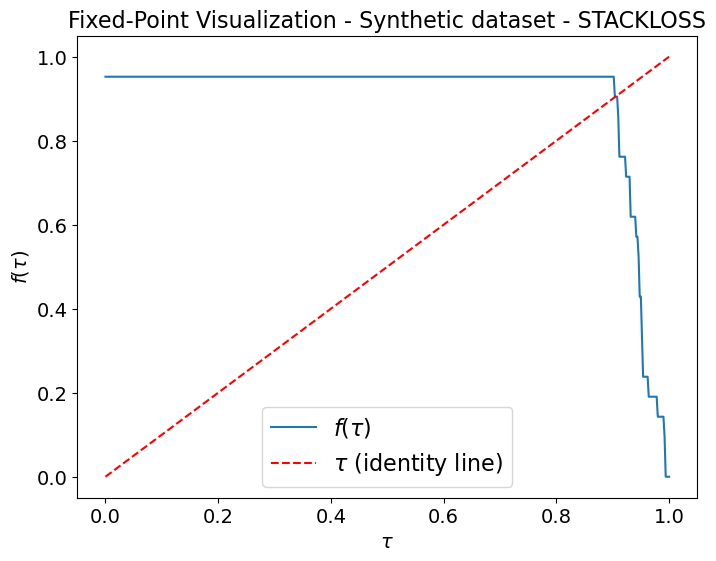

SCAS: 0.904761911691637
r2 score: 0.56795125384425
A(0.05): 0.42857142857142855
A(0.1): 0.42857142857142855
A(0.2): 0.42857142857142855
A(0.5): 0.42857142857142855


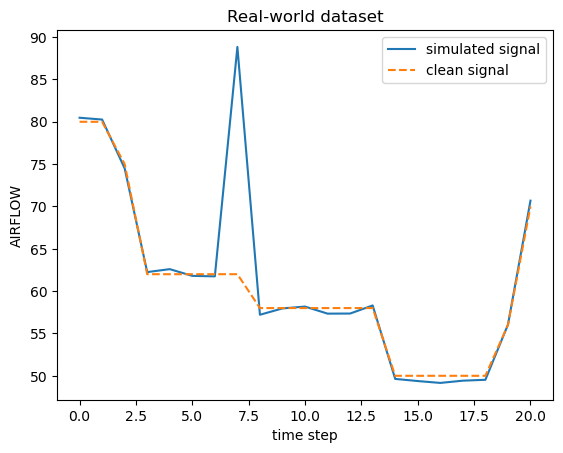

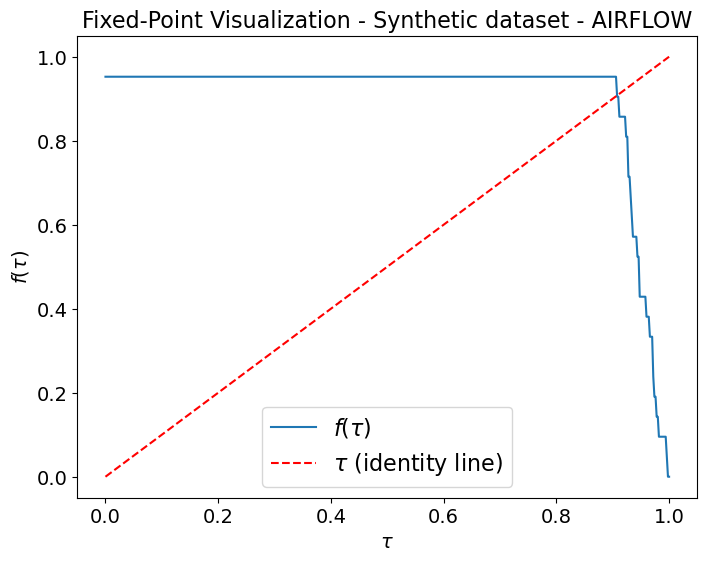

SCAS: 0.9082701732810913
r2 score: 0.5684958216984186
A(0.05): 0.42857142857142855
A(0.1): 0.42857142857142855
A(0.2): 0.42857142857142855
A(0.5): 0.42857142857142855


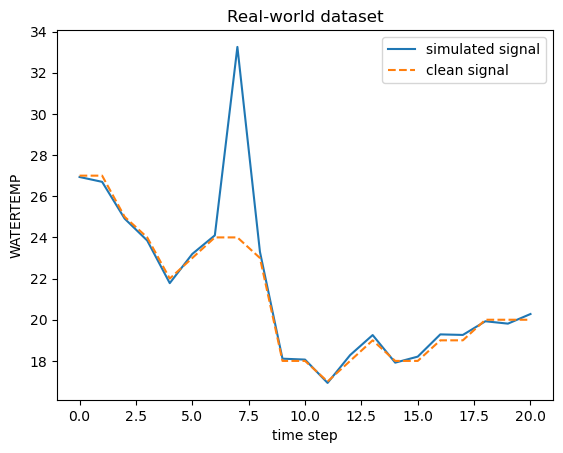

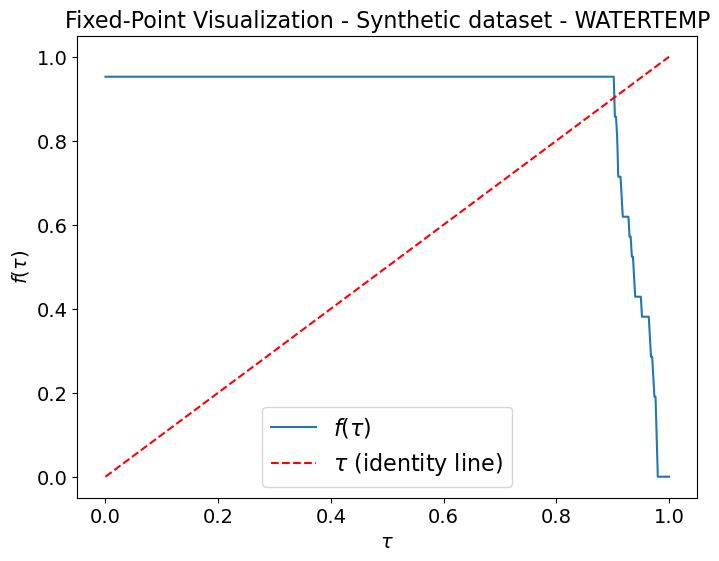

SCAS: 0.904762136326675
r2 score: 0.5674159173698534
A(0.05): 0.42857142857142855
A(0.1): 0.42857142857142855
A(0.2): 0.42857142857142855
A(0.5): 0.42857142857142855


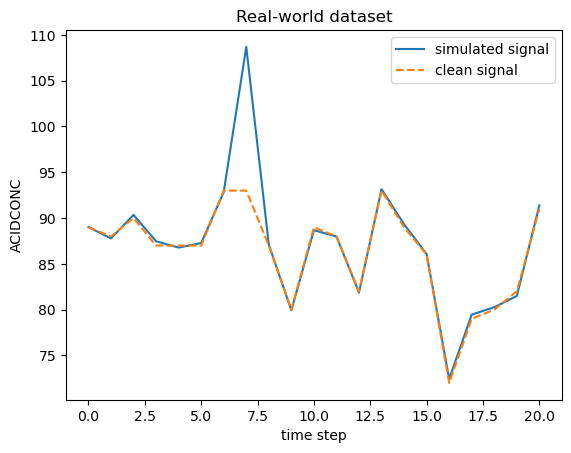

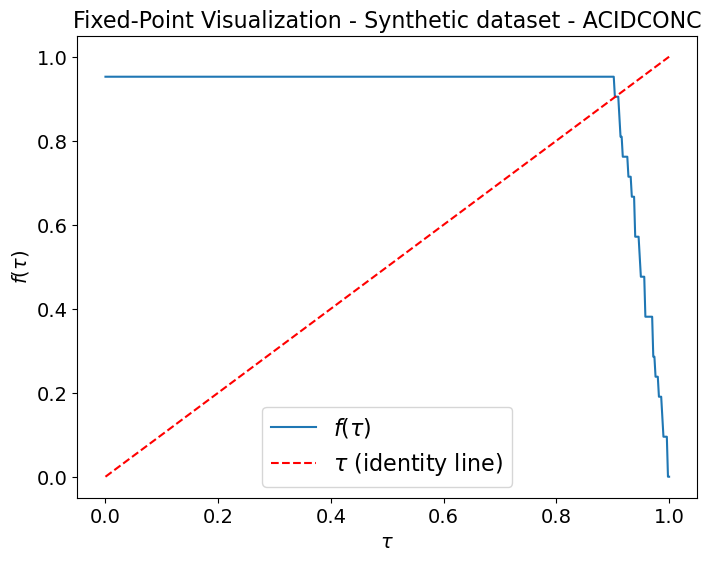

SCAS: 0.9047619057416949
r2 score: 0.5685218647245516
A(0.05): 0.5238095238095238
A(0.1): 0.5238095238095238
A(0.2): 0.5238095238095238
A(0.5): 0.5238095238095238


In [19]:
x = np.arange(0, 21)

for col in data.columns:
    y_true = data[col]
    sd = np.std(y_true)
    
    y_sim = y_true + np.random.uniform(-0.1*sd, 0.1*sd, size=len(x))
    y_sim[7] = y_true[7] + 3*sd
    plt.plot(x, y_sim, label='simulated signal')
    plt.plot(x, y_true, linestyle='dashed', label='clean signal')
    plt.ylabel(col)
    plt.xlabel('time step')
    plt.title('Real-world dataset')
    plt.legend()
    plt.savefig(f'New dataset Figure - {col} dataset with an outlier', dpi=900)
    plt.show()

    find_tau(y_true, y_sim, name=f'Synthetic dataset - {col}')
    print(f'SCAS: {SCAS(y_true, y_sim)}')
    print(f'r2 score: {r2_score(y_true, y_sim)}')
    for k in [0.05, 0.1, 0.2, 0.5]:
        print(f'A({k}): {TBA(y_true, y_sim)}')

# Experiment 2: Contamination Analysis

In [55]:
_rng = np.random.default_rng(123)

# --------------------------
# Synthetic data generators
# --------------------------
def sample_clean_signal(dist, n, rng=None):
    """
    Draw y from the specified distribution. 
    """
    rng = _rng if rng is None else rng
    if dist == "normal":
        return rng.normal(loc=0.0, scale=1.0, size=n)
    if dist == "t3":
        # centre at 0; variance finite (3/(3-2)) so this is heavy-tailed
        return rng.standard_t(df=3, size=n)
    if dist == "laplace":
        return rng.laplace(loc=0.0, scale=1.0, size=n)  # unit sd
    raise ValueError("Unknown dist")

def draw_noise(kind, n, rng=None):
    if kind == "gauss":
        return rng.normal(size=n)
    if kind == "laplace":
        return rng.laplace(scale=1/np.sqrt(2), size=n)  # unit sd
    raise ValueError("unknown noise")

# --------------------------
# Contamination mechanism
# --------------------------
def contaminate_predictions(y_true, y_pred_clean, contam_frac, noise_kind, scale_mult, rng,
                            prefer_scale="sd"):
    """
    Contaminate a fraction of points by adding noise ~ (scale_mult * sigma_ref) * D,
    where D is unit-sd Gaussian or Laplace. sigma_ref is computed from y_true.
    """
    y_true = np.asarray(y_true)
    y_pred_clean = np.asarray(y_pred_clean)

    n = len(y_true)
    m = int(np.floor(contam_frac * n))
    if contam_frac > 0 and m == 0:
        m = 1
    idx = np.arange(n) if contam_frac >= 1.0 else rng.choice(n, size=m, replace=False)

    sigma_ref = _scale_y(y_true, prefer=prefer_scale)
    noise = scale_mult * sigma_ref * draw_noise(noise_kind, len(idx), rng)

    y_pred = y_pred_clean.copy()
    y_pred[idx] = y_pred[idx] + noise
    return y_pred

## Datasets

In [59]:
# --------------------------
# Experiment A: Synthetic dataset
# --------------------------
def run_contamination_synthetic(
    dists=("normal", "t3", "laplace"),
    Ns=(20, 50, 100),
    contam_fracs=(0.10, 0.50, 1.00),
    noise_kinds=("gauss", "laplace"),
    scales=(0.5, 1.0, 1.5, 2.0),
    R=1000,
    seed=42,
    ks=(0.05, 0.1, 0.2, 0.5),
):
    rng0 = np.random.default_rng(seed)
    rows = []

    for dist in dists:
        for N in Ns:
            for contam in contam_fracs:
                for nk in noise_kinds:
                    for sc in scales:
                        for _ in range(R):
                            rng = np.random.default_rng(rng0.integers(0, 2**31 - 1))
                            y_true = sample_clean_signal(dist, N, rng)

                            # baseline: perfect prediction, then contaminate a fraction
                            y_pred_clean = y_true.copy()
                            y_pred = contaminate_predictions(
                                y_true, y_pred_clean,
                                contam_frac=contam, noise_kind=nk, scale_mult=sc,
                                rng=rng, prefer_scale="sd"
                            )

                            mets = compute_metrics(y_true, y_pred, ks=ks, prefer_scale="sd")
                            rows.append({
                                "dataset": "synthetic",
                                "dist": dist,
                                "N": N,
                                "contam_frac": contam,
                                "contam_noise": nk,
                                "scale_mult": sc,
                                **mets
                            })

    return pd.DataFrame(rows)

# --------------------------
# Experiment B: Stackloss (real-world dataset)
# --------------------------
def load_stackloss():
    try:
        import statsmodels.api as sm
        data = sm.datasets.stackloss.load_pandas().data
        return {
            "stackloss": data["STACKLOSS"].to_numpy(),
            "air_flow":  data["AIRFLOW"].to_numpy(),
            "water_temp": data["WATERTEMP"].to_numpy(),
            "acid_conc": data["ACIDCONC"].to_numpy(),
        }
    except Exception as e:
        raise RuntimeError(
            "Could not load stackloss via statsmodels. "
            "Install statsmodels (pip install statsmodels) or provide the dataset manually."
        ) from e

def run_contamination_stackloss(
    contam_fracs=(0.10, 0.50, 1.00),
    noise_kinds=("gauss", "laplace"),
    scales=(0.5, 1.0, 1.5, 2.0),
    R=1000,
    seed=123,
    ks=(0.05, 0.1, 0.2, 0.5),
):
    signals = load_stackloss()
    rng0 = np.random.default_rng(seed)
    rows = []

    for signal_name, y_true in signals.items():
        for contam in contam_fracs:
            for nk in noise_kinds:
                for sc in scales:
                    for _ in range(R):
                        rng = np.random.default_rng(rng0.integers(0, 2**31 - 1))
                        y_pred = contaminate_predictions(
                            y_true, y_true.copy(),
                            contam_frac=contam, noise_kind=nk, scale_mult=sc,
                            rng=rng, prefer_scale="sd"
                        )
                        mets = compute_metrics(y_true, y_pred, ks=ks, prefer_scale="sd")
                        rows.append({
                            "dataset": "stackloss",
                            "signal": signal_name,
                            "contam_frac": contam,
                            "contam_noise": nk,
                            "scale_mult": sc,
                            **mets
                        })

    return pd.DataFrame(rows)

In [61]:
Ks = [0.05, 0.1, 0.2, 0.5]

df_syn = run_contamination_synthetic(
    dists=("normal", "t3", "laplace"),
    Ns=(20, 50, 100),
    contam_fracs=(0.10, 0.50, 1.00),
    noise_kinds=("gauss", "laplace"),
    scales=(0.5, 1.0, 1.5, 2.0),
    R=1000,
    seed=42,
    ks=Ks,
)

df_stk = run_contamination_stackloss(
    contam_fracs=(0.10, 0.50, 1.00),
    noise_kinds=("gauss", "laplace"),
    scales=(0.5, 1.0, 1.5, 2.0),
    R=1000, 
    seed=123,
    ks=Ks,
)

## Generate plots

In [62]:
def generate_all_comparison_curves(
    df, dataset="synthetic", outdir="final_results_scas/curves",
    metrics=("R2", "SCAS", "A(0.05)", "A(0.1)", "A(0.2)" ,"A(0.5)"),
    Ns=None, contam_fracs=(0.10, 0.50, 1.00), noise_kinds=("gauss", "laplace"),
):
    os.makedirs(outdir, exist_ok=True)
    if dataset == "synthetic":
        if Ns is None:
            Ns = sorted(df["N"].unique())
        dists = sorted(df["dist"].unique())
        subsets = [
            (df.query(f"dist=='{d}' & N=={int(N)} & contam_frac=={cf} & contam_noise=='{nk}'"),
             f"Synthetic ({d}), N={N}, {int(100*cf)}% contam, {nk}",
             f"SYN_CURVE_{d}_N{N}_{int(100*cf)}pct_{nk}.png")
            for d in dists for N in Ns for nk in noise_kinds for cf in contam_fracs
        ]
    else:
        signals = sorted(df["signal"].unique())
        subsets = [
            (df.query(f"signal=='{s}' & contam_frac=={cf} & contam_noise=='{nk}'"),
             f"Stackloss ({s}), {int(100*cf)}% contam, {nk}",
             f"STK_CURVE_{s}_{int(100*cf)}pct_{nk}.png")
            for s in signals for nk in noise_kinds for cf in contam_fracs
        ]
    for sub, title, fname in subsets:
        if sub.empty:
            continue
        fig, ax = plt.subplots(figsize=(6, 4))
        for m in metrics:
            if m not in sub.columns:
                continue
            med = sub.groupby("scale_mult")[m].median().reset_index().sort_values("scale_mult")
            st = STYLE.get(m, {"color": "gray", "marker": "o", "linestyle": "--", "label": m})
            ax.plot(med["scale_mult"], med[m], marker=st["marker"], linestyle=st["linestyle"],
                    color=st["color"], label=st["label"])
        ax.set_title(title)
        ax.set_xlabel("Contamination scale (× σ_ref)")
        ax.set_ylabel("Median metric")
        ax.set_ylim(-1, 1)
        ax.grid(False)
        ax.legend()
        plt.tight_layout()
        fig.savefig(os.path.join(outdir, fname), dpi=1200)
        plt.close(fig)

In [63]:
def generate_all_boxplots(
    df, dataset="synthetic", outdir="final_results_scas/boxplots",
    metrics=("R2", "SCAS", "A(0.05)", "A(0.1)", "A(0.2)" ,"A(0.5)"),
    Ns=None, contam_fracs=(0.10, 0.50, 1.0), scales=(2.0,), noise_kinds=("gauss", "laplace"),
):
    os.makedirs(outdir, exist_ok=True)
    if dataset == "synthetic":
        if Ns is None:
            Ns = sorted(df["N"].unique())
        dists = sorted(df["dist"].unique())
        subsets = [
            (df.query(f"dist=='{d}' & N=={int(N)} & contam_frac=={cf} & contam_noise=='{nk}' & scale_mult=={sc}"),
             f"Synthetic ({d}), N={N}, {int(100*cf)}% contam, {sc}σ, {nk}",
             f"SYN_BOX_{d}_N{N}_{int(100*cf)}pct_{sc}sig_{nk}.png")
            for d in dists for N in Ns for nk in noise_kinds for cf in contam_fracs for sc in scales
        ]
    else:
        signals = sorted(df["signal"].unique())
        subsets = [
            (df.query(f"signal=='{s}' & contam_frac=={cf} & contam_noise=='{nk}' & scale_mult=={sc}"),
             f"Stackloss ({s}), {int(100*cf)}% contam, {sc}σ, {nk}",
             f"STK_BOX_{s}_{int(100*cf)}pct_{sc}sig_{nk}.png")
            for s in signals for nk in noise_kinds for cf in contam_fracs for sc in scales
        ]
    for sub, title, fname in subsets:
        if sub.empty:
            continue
        data   = [sub[m].values          for m in metrics if m in sub.columns]
        labels = [m for m in metrics if m in sub.columns]
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.boxplot(data, labels=labels, showfliers=False)
        ax.set_title(title)
        ax.set_ylabel("Metric value")
        ax.set_ylim(-0.5, 1)
        ax.grid(True, axis="y", linestyle="--", alpha=0.5)
        plt.tight_layout()
        fig.savefig(os.path.join(outdir, fname), dpi=1200)
        plt.close(fig)

In [64]:
def generate_all_heatmaps(
    df, dataset="synthetic", outdir="final_results_scas/heatmaps",
    metrics = ("R2", "SCAS", "A(0.05)", "A(0.1)", "A(0.2)" ,"A(0.5)"),
    Ns=None, contam_fracs=(0.10, 0.50, 1.0), noise_kinds=("gauss", "laplace"),
):
    os.makedirs(outdir, exist_ok=True)
    if dataset == "synthetic":
        if Ns is None:
            Ns = sorted(df["N"].unique())
        dists = sorted(df["dist"].unique())
        subsets = [
            (df[(df["dist"]==d) & (df["N"]==N) & (df["contam_noise"]==nk)],
             f"Synthetic ({d}), N={N}, {nk}",
             f"SYN_HEAT_{{m}}_{d}_N{N}_{nk}.png")
            for d in dists for N in Ns for nk in noise_kinds
        ]
    else:
        signals = sorted(df["signal"].unique())
        subsets = [
            (df[(df["signal"]==s) & (df["contam_noise"]==nk)],
             f"Stackloss ({s}), {nk}",
             f"STK_HEAT_{{m}}_{s}_{nk}.png")
            for s in signals for nk in noise_kinds
        ]
    for sub, title_tpl, fname_tpl in subsets:
        if sub.empty:
            continue
        for m in metrics:
            if m not in sub.columns:
                continue
            piv = (sub.groupby(["contam_frac", "scale_mult"])[m].median()
                      .reset_index()
                      .pivot_table(index="contam_frac", columns="scale_mult", values=m, aggfunc="first")
                      .sort_index())
            fig, ax = plt.subplots(figsize=(6, 4))
            im = ax.imshow(piv.values, aspect="auto", origin="lower", cmap="viridis")
            ax.set_xticks(np.arange(len(piv.columns)))
            ax.set_xticklabels([str(c) for c in piv.columns])
            ax.set_yticks(np.arange(len(piv.index)))
            ax.set_yticklabels([f"{int(100*r)}%" for r in piv.index])
            ax.set_xlabel("Contamination scale (× σ_ref)")
            ax.set_ylabel("Contamination fraction")
            ax.set_title(f"{title_tpl} — {m}")
            fig.colorbar(im, ax=ax).set_label(m)
            plt.tight_layout()
            fig.savefig(os.path.join(outdir, fname_tpl.format(m=m)), dpi=1200)
            plt.close(fig)

MemoryError: Unable to allocate 16.6 MiB for an array with shape (3675, 4727) and data type bool

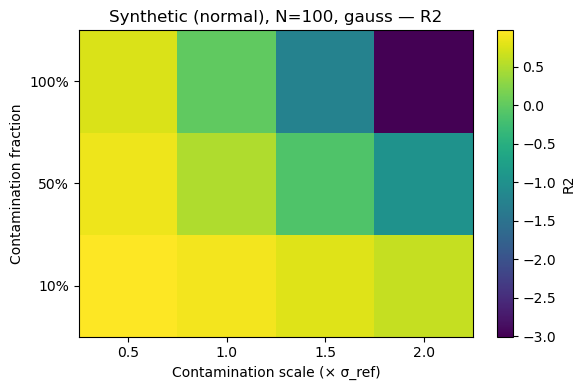

In [65]:
generate_all_comparison_curves(df_syn, dataset="synthetic")
generate_all_comparison_curves(df_stk, dataset="stackloss")

generate_all_boxplots(df_syn, dataset="synthetic")
generate_all_boxplots(df_stk, dataset="stackloss")

# --- EXTENDED DIAGNOSTICS ---
generate_all_heatmaps(df_syn, dataset="synthetic")
generate_all_heatmaps(df_stk, dataset="stackloss")

# Experiment 3: Bias Sensitivity

In [172]:
_rng = np.random.default_rng(123)

def sample_y(dist, n, rng=None):
    """
    Draw y from the specified distribution. 
    """
    rng = _rng if rng is None else rng
    if dist == "normal":
        return rng.normal(loc=100.0, scale=10.0, size=n)
    if dist == "laplace":
        return rng.laplace(loc=100.0, scale=10.0, size=n)  # unit sd
    raise ValueError("Unknown dist")

In [206]:
def run_bias_sensitivity(dists=("normal", "laplace","gamma_k1","cauchy"),
                         N=100, 
                         bias_levels_add=None,
                         bias_levels_mult=None,
                         R=1000, seed=42):
    rng0 = np.random.default_rng(seed)
    rows = []
    if bias_levels_add is None:
        bias_levels_add = np.linspace(-1, 1, 19)        # multiples of sigma
    if bias_levels_mult is None:
        bias_levels_mult = np.linspace(0.85, 1.15, 19)  # multiplicative factor

    for dist in dists:
        for r in range(R):
            rng = np.random.default_rng(rng0.integers(0, 2**31-1))
            y = sample_y(dist, N, rng=rng)
            sigma = np.std(y)

            # additive bias
            for b in bias_levels_add:
                yhat = y + b * sigma
                row = {"dist": dist, "N": N, "bias_type": "add", "bias_level": b}
                row["SCAS"] = SCAS(y, yhat)
                row["R2"]  = R2(y, yhat)
                for k in [0.05, 0.1, 0.2, 0.5]:
                    row[f"A({k})"] = TBA(y, yhat, k=k)
                rows.append(row)

            # multiplicative bias
            for m in bias_levels_mult:
                yhat = m * y
                row = {"dist": dist, "N": N, "bias_type": "mult", "bias_level": m}
                row["SCAS"] = SCAS(y, yhat)
                row["R2"]  = R2(y, yhat)
                for k in [0.05, 0.1, 0.2, 0.5]:
                    row[f"A({k})"] = TBA(y, yhat, k=k)
                rows.append(row)
    return pd.DataFrame(rows)


In [241]:
def plot_bias_curves(df_bias, dist, bias_type="add"):
    metrics = ["R2", "SCAS", "A(0.05)", "A(0.1)", "A(0.2)" ,"A(0.5)"]
    sub = df_bias[(df_bias["dist"]==dist) & (df_bias["bias_type"]==bias_type)]
    levels = sorted(sub["bias_level"].unique())

    fig, ax = plt.subplots(figsize=(6,4))
    for m in metrics:
        med = sub.groupby("bias_level")[m].median().reindex(levels)
        st = STYLE.get(m, {"color":"gray","marker":"o","linestyle":"--","label":m})
        ax.plot(levels, med, marker=st["marker"], linestyle=st["linestyle"],
                color=st["color"], label=st["label"])
    if bias_type == 'add':
        ax.axvline(0, color="k", linestyle=":")
    if bias_type == 'mul':
        ax.axvline(1, color="k", linestyle=":")
    ax.set_xlabel("Bias level" + (" (×σ)" if bias_type=="add" else " (multiplicative factor)"))
    ax.set_ylabel("Metric value")
    ax.set_title(f"Bias sensitivity ({bias_type})")
    ax.legend(ncols=3, fontsize=8, loc='lower center', bbox_to_anchor=(0.5, 0.05))
    ax.grid(True, alpha=0.3)
    plt.savefig(f'bias_plot_{bias_type}.png', dpi=600)
    plt.show()


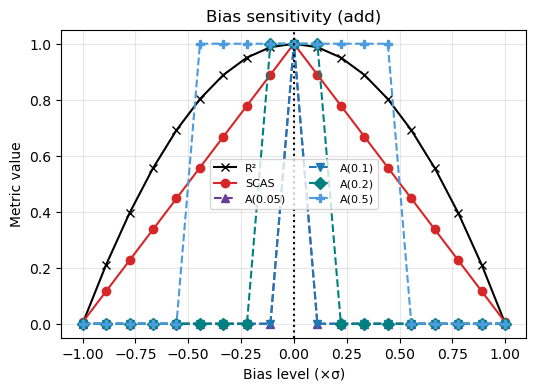

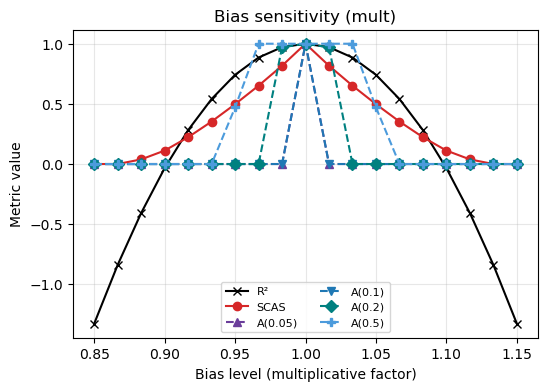

In [212]:
# Run experiment
df_bias = run_bias_sensitivity(dists=("normal", "laplace"))

# Additive bias plot
plot_bias_curves(df_bias, dist="normal", bias_type="add")

# Multiplicative bias plot
plot_bias_curves(df_bias, dist="normal", bias_type="mult")